
# Simulazione di caching basato su similarità di prompt (CLIP) con due politiche di eviction: LRU e LFU



In [22]:

import random
import itertools
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from collections import defaultdict
from transformers import CLIPTokenizer, CLIPModel
import torch.nn.functional as F
from sklearn.cluster import KMeans



### Setup device (MPS su Mac, altrimenti CPU)


In [23]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using Apple MPS device


## Setup CLIP per embedding testuale

In [24]:
clip_model_name = "openai/clip-vit-base-patch32"
tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)
model = CLIPModel.from_pretrained(clip_model_name).to(device)
model.eval()

def embed_prompt(prompt: str) -> torch.Tensor:
    """
    Ritorna embedding L2-normalizzato del prompt.
    """
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        emb = model.get_text_features(**inputs)
    return emb / emb.norm(p=2, dim=-1, keepdim=True)

## Gestione del dataset

In [25]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from collections import defaultdict
import random

class PromptDatasetManager:
    def __init__(self):
        self.df: pd.DataFrame = None
        self.emb_matrix: np.ndarray = None
        self.meta_path: str = None

    def load_local_metadata(self, path: str, max_rows: int = None, load_embeddings: bool = True):
        """
        Carica metadata+embedding da Parquet.
        Se max_rows è specificato, tiene solo le prime max_rows righe.
        Se load_embeddings=False, differisce la costruzione di self.emb_matrix.
        """
        self.meta_path = path
        table = pq.read_table(path, columns=['prompt', 'clip_emb', 'user_name', 'timestamp'])
        if max_rows:
            table = table.slice(0, max_rows)
        self.df = table.to_pandas()
        if load_embeddings:
            self._build_embedding_matrix()

    def load_remote_metadata(self, repo_id: str, filename: str, max_rows: int = None, load_embeddings: bool = True):
        """
        Stesso di sopra, scaricando da HuggingFace Hub.
        """
        from huggingface_hub import hf_hub_download
        self.meta_path = hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset")
        self.load_local_metadata(self.meta_path, max_rows=max_rows, load_embeddings=load_embeddings)

    def _build_embedding_matrix(self):
        """Costruisce self.emb_matrix da self.df['clip_emb']."""
        if self.emb_matrix is None:
            self.emb_matrix = np.vstack(self.df['clip_emb'].values).astype(np.float32)

    def get_prompt_and_embedding(self, idx: int):
        """
        Ritorna (prompt, embedding) per una riga idx.
        Costruisce emb_matrix se serve.
        """
        self._build_embedding_matrix()
        return self.df.at[idx, 'prompt'], self.emb_matrix[idx]

    def get_all_prompts_and_embeddings(self):
        """
        Ritorna (list_of_prompts, emb_matrix).
        """
        self._build_embedding_matrix()
        return self.df['prompt'].tolist(), self.emb_matrix

    def _get_user_sessions(self, user_name: str, session_gap: int = 30) -> pd.DataFrame:
        # <-- identica alla tua implementazione originale -->
        if 'user_name' not in self.df.columns or 'timestamp' not in self.df.columns:
            raise ValueError("Le colonne 'user_name' e/o 'timestamp' non sono presenti.")
        df_user = self.df[self.df['user_name'] == user_name].copy()
        if df_user.empty:
            raise ValueError(f"Nessun dato per l'utente {user_name}")
        df_user = df_user.sort_values('timestamp').reset_index(drop=True)
        df_user['session_delta'] = df_user['timestamp'].diff().dt.total_seconds() / 60.0
        session_ids = []
        current_id = 0
        for delta in df_user['session_delta']:
            if pd.isna(delta) or delta > session_gap:
                current_id += 1
            session_ids.append(current_id)
        df_user['session_id'] = session_ids
        return df_user

    def executeFunctionOnDataFrame(self, func, *args, **kwargs):
        if not callable(func):
            raise ValueError("Il parametro 'func' deve essere una funzione chiamabile.")
        return func(self.df, *args, **kwargs)

    def getDataFrame(self):
        return self.df

    def getPrompts(self,
                   limit: int = None,
                   shuffle: bool = True,
                   include_embeddings: bool = False):
        """
        Se include_embeddings=False (default), ritorna list[str].
        Se True, ritorna list[(str, np.ndarray)].
        """
        prompts = self.df['prompt'].dropna().tolist()
        if shuffle:
            random.shuffle(prompts)
        if limit is not None:
            prompts = prompts[:limit]

        if include_embeddings:
            self._build_embedding_matrix()
            # recupera gli indici originari corrispondenti ai prompt selezionati
            indices = self.df[self.df['prompt'].isin(prompts)].index.tolist()
            return [(self.df.at[i, 'prompt'], self.emb_matrix[i]) for i in indices]

        return prompts

    def getUsersPrompts(self,
                        limit: int = None,
                        shuffle: bool = True,
                        include_embeddings: bool = False):
        """
        Se include_embeddings=True, per ogni utente restituisce list[(prompt, embedding)].
        """
        users = self.df['user_name'].dropna().unique().tolist()
        if shuffle:
            random.shuffle(users)
        if limit is not None:
            users = users[:limit]

        if include_embeddings:
            self._build_embedding_matrix()
        user_prompts = {}
        for u in users:
            df_u = self.df[self.df['user_name'] == u]
            prompts = df_u['prompt'].dropna().tolist()
            if include_embeddings:
                idxs = df_u.index.tolist()
                user_prompts[u] = [(self.df.at[i, 'prompt'], self.emb_matrix[i]) for i in idxs]
            else:
                user_prompts[u] = prompts
        return user_prompts

    def getSessionsPrompts(self,
                           session_gap: int = 30,
                           limit: int = None,
                           shuffle: bool = True,
                           include_embeddings: bool = False):
        """
        Ritorna dict[user] = dict[session_id] = list[prompt] o list[(prompt,embedding)].
        """
        users = self.df['user_name'].dropna().unique().tolist()
        if shuffle:
            random.shuffle(users)
        if limit is not None:
            users = users[:limit]

        if include_embeddings:
            self._build_embedding_matrix()

        user_sessions = {}
        for u in users:
            df_u = self._get_user_sessions(u, session_gap=session_gap)
            sessions = defaultdict(list)
            for _, row in df_u.iterrows():
                if include_embeddings:
                    emb = self.emb_matrix[row.name]
                    sessions[row['session_id']].append((row['prompt'], emb))
                else:
                    sessions[row['session_id']].append(row['prompt'])
            user_sessions[u] = dict(sessions)
        return user_sessions

    def retRandomPrompt(self, include_embedding: bool = False):
        """
        Restituisce lambda() -> prompt o -> (prompt, embedding).
        """
        prompts = self.df['prompt'].dropna().tolist()
        if include_embedding:
            self._build_embedding_matrix()
            idxs = list(self.df[self.df['prompt'].isin(prompts)].index)
            return lambda: (
                self.df.at[i := random.choice(idxs), 'prompt'],
                self.emb_matrix[i]
            )
        else:
            return lambda: random.choice(prompts)

    def retRandomSession(self, session_gap: int = 30, max_prompts: int = None, include_embeddings: bool = False):
        """
        Restituisce funzione che sceglie un utente a caso e una sua sessione.
        Se include_embeddings=True, ogni prompt è tuple (prompt, emb).
        """
        users = self.df['user_name'].dropna().unique().tolist()
        if not users:
            raise ValueError("Nessun utente trovato nel DataFrame.")
        if include_embeddings:
            self._build_embedding_matrix()

        def gen():
            u = random.choice(users)
            df_u = self._get_user_sessions(u, session_gap)
            if df_u.empty:
                raise ValueError(f"Nessuna sessione trovata per l'utente {u}")
            # scegli una sessione a caso
            sess_id = random.choice(df_u['session_id'].unique().tolist())
            df_s = df_u[df_u['session_id'] == sess_id]
            prompts = df_s['prompt'].tolist()
            if include_embeddings:
                idxs = df_s.index.tolist()
                items = [(self.df.at[i, 'prompt'], self.emb_matrix[i]) for i in idxs]
            else:
                items = prompts
            if max_prompts:
                items = items[:max_prompts]
            return u, sess_id, items

        return gen


In [26]:
manager = PromptDatasetManager()

manager.load_local_metadata(
    path="/Users/tella/Workspace/Inria/Data/normalized_embeddings.parquet",
    max_rows=None # Limita per testare velocemente
)

In [27]:
prompts = manager.getPrompts(limit=None, include_embeddings=True)
print(f"Loaded {len(prompts)} prompts with embeddings.")
for prompt, emb in prompts[:1]:
    print(f"Prompt: {prompt}\nEmbedding: {emb[:5]}... (truncated)\n")

Loaded 2000000 prompts with embeddings.
Prompt: a portrait of a female robot made from code, very intricate details, octane render, 8 k, trending on artstation 
Embedding: [ 0.0014396   0.00907412 -0.07621925 -0.01913876 -0.00966171]... (truncated)



### KAGGLE CODE
Funzione per calcolare gli embeddings CLIP e salvarli in un file Parquet. Valuta direttamente supporti per TPU e GPU, altrimenti CPU.

In [28]:
import random
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import torch
from huggingface_hub import hf_hub_download
from collections import OrderedDict, defaultdict
from transformers import CLIPTokenizer, CLIPTextModel
import threading, queue, math
from tqdm import tqdm


# Se torch_xla è installato (TPU), importalo; altrimenti lo ignori
try:
    import torch_xla.core.xla_model as xm
    TPU_AVAILABLE = True
except ImportError:
    TPU_AVAILABLE = False

In [29]:
def add_clip_embeddings_auto(
    meta_path: str,
    output_path: str,
    batch_size: int = 4096,
    prefetch: int = 2
):
    """
    Streaming Parquet → batch → tokenizza su CPU → inferisce su
    TPU (torch_xla) / GPU (CUDA) / CPU → scrive parquet con colonna `clip_emb`.
    """
    reader = pq.ParquetFile(meta_path)
    total_rows    = reader.metadata.num_rows

    # --- Device selection e conteggio ---
    if TPU_AVAILABLE:
        device    = xm.xla_device()
        n_devices = xm.xrt_world_size()
        print(f"▶ Using TPU: {n_devices} core(s), device={device}")
    elif torch.cuda.is_available():
        n_devices = torch.cuda.device_count()
        device    = torch.device("cuda")
        names     = [torch.cuda.get_device_name(i) for i in range(n_devices)]
        print(f"▶ Using {n_devices} GPU(s): {names}")
    else:
        n_devices = 1
        device    = torch.device("cpu")
        print("▶ CUDA/TPU non disponibile, uso CPU")

    # Adatto batch_size a multiplo di n_devices
    per_dev_bs     = max(1, batch_size // n_devices)
    batch_size_glb = per_dev_bs * n_devices
    if batch_size_glb != batch_size:
        print(f"Aggiusto batch_size: {batch_size} → {batch_size_glb}  ({per_dev_bs}×{n_devices})")
    batch_size    = batch_size_glb
    total_batches = math.ceil(total_rows / batch_size)

    # --- Writer setup ---
    schema_out = reader.schema_arrow.append(
        pa.field("clip_emb", pa.list_(pa.float32()))
    )
    writer = pq.ParquetWriter(output_path, schema_out, compression=None)

    # --- Tokenizer & Model setup ---
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32") \
                            .to(device).half()
    if not TPU_AVAILABLE and n_devices > 1 and device.type == "cuda":
        model = torch.nn.DataParallel(model)
    model = torch.compile(model)
    model.eval()

    # Coda per pipeline producer/consumer
    q = queue.Queue(prefetch)

    def producer():
        for batch in reader.iter_batches(batch_size=batch_size):
            tbl     = pa.Table.from_batches([batch])
            prompts = tbl.column("prompt").to_pylist()
            toks    = tokenizer(prompts,
                                padding=True,
                                truncation=True,
                                return_tensors="pt")
            q.put((tbl, toks))
        q.put(None)

    def consumer():
        pbar = tqdm(total=total_batches, desc="CLIP embeddings", unit="batch")
        while True:
            item = q.get()
            if item is None:
                break
            tbl, toks = item
            toks = {k: v.to(device, non_blocking=True) for k, v in toks.items()}

            if TPU_AVAILABLE:
                with torch.no_grad():
                    emb = model(**toks).pooler_output.cpu().numpy()
            else:
                # mixed‑precision solo su CUDA
                with torch.cuda.amp.autocast(enabled=(device.type=="cuda")), torch.no_grad():
                    emb = model(**toks).pooler_output.cpu().numpy()

            tbl = tbl.append_column(
                "clip_emb",
                pa.array(emb.tolist(), type=pa.list_(pa.float32()))
            )
            writer.write_table(tbl)
            pbar.update(1)
        pbar.close()
        writer.close()

    t1 = threading.Thread(target=producer, daemon=True)
    t2 = threading.Thread(target=consumer, daemon=True)
    t1.start(); t2.start()
    t1.join(); t2.join()

    # Ricarico in pandas per usi successivi
    print(f"Embeddings calcolati e salvati in: {output_path}")
    return pd.read_parquet(output_path)

## Valutazione della similarità intra-sessione, extra-sessione e same-user

In [44]:
import numpy as np
from typing import List, Tuple

def compute_intra_session_sims(
    manager,
    num_sessions: int = None,
    session_gap: int = 30,
    max_prompts: int = None
) -> List[float]:
    """
    Estrae fino a `num_sessions` sessioni casuali (gap = session_gap minuti),
    e per ciascuna calcola in O(n·D) la media dei dot‑product tra vettori
    consecutivi (fino a `max_prompts`). Restituisce la lista delle medie.
    """
    # Prendo _solo_ embeddings strutturati per sessione
    user_sessions = manager.getSessionsPrompts(
        session_gap=session_gap,
        limit=num_sessions,
        shuffle=True,
        include_embeddings=True
    )

    sims = []
    # Flatten: prima raccolgo tutte le matrici (n_i, D)
    mats = []
    for sessions in user_sessions.values():
        for items in sessions.values():
            if len(items) > 1:
                # prende fino a max_prompts e costruisce (k, D)
                emb_mat = np.stack([emb for _, emb in items[:max_prompts]])
                mats.append(emb_mat)
                if len(mats) >= num_sessions:
                    break
        if len(mats) >= num_sessions:
            break

    # Per ogni matrice calcolo media dei dot tra righe consecutive
    for M in mats:
        # (M[1:] * M[:-1]).sum(axis=1) → vettore di lunghezza n-1
        dots = np.einsum('ij,ij->i', M[1:], M[:-1])
        sims.append(float(dots.mean()))

    return sims


def compute_extra_session_sims(
    manager,
    num_pairs: int = None
) -> List[float]:
    """
    Prende 2*num_pairs embedding a caso (limitando a esattamente 2*num_pairs),
    li accoppia in ordine (0-1, 2-3, …) e calcola tutti i dot product in batch.
    """
    # 1) Prendi fino a 2*num_pairs tuple (prompt, emb)
    items: List[Tuple[str, np.ndarray]] = manager.getPrompts(
        limit=2 * num_pairs,
        shuffle=True,
        include_embeddings=True
    )

    if len(items) < 2 * num_pairs:
        raise ValueError(
            f"Non ci sono abbastanza embedding: "
            f"trovati {len(items)}, ma servono {2 * num_pairs}"
        )

    # 2) Limita a esattamente 2*num_pairs
    items = items[:2 * num_pairs]

    # 3) Costruisci la matrice (2*num_pairs, D)
    E = np.stack([emb for _, emb in items], axis=0)

    # 4) Split in due array (num_pairs, D)
    E1 = E[0::2]
    E2 = E[1::2]

    # 5) Dot product riga‑riga in batch
    #    equivale a np.sum(E1 * E2, axis=1)
    dots = np.einsum('ij,ij->i', E1, E2)

    return dots.tolist()




def compute_user_sims(
    manager,
    num_pairs: int = None
) -> List[float]:
    """
    Per `num_pairs` coppie, pesca randomicamente embedding dallo stesso utente,
    calcola tutti i dot in batch (per utente) e poi concatena finché raggiunge num_pairs.
    """
    user_prompts = manager.getUsersPrompts(
        limit=num_pairs * 2,
        shuffle=True,
        include_embeddings=True
    )

    sims = []
    needed = num_pairs
    for items in user_prompts.values():
        if needed <= 0:
            break
        embs = np.stack([emb for _, emb in items], axis=0)  # (m, D)
        m = embs.shape[0]
        if m < 2:
            continue

        # quanti campioni prendo da questo utente
        k = needed
        # genero k coppie di indici in [0,m)
        # shape (k,2)
        idx = np.random.randint(0, m, size=(k, 2))
        # evito auto‐sim (facoltativo): se idx[i,0]==idx[i,1], li rigenero…
        mask = idx[:,0] == idx[:,1]
        while mask.any():
            idx[mask] = np.random.randint(0, m, size=(mask.sum(), 2))
            mask = idx[:,0] == idx[:,1]

        # raccolgo i dot in batch
        v1 = embs[idx[:,0]]
        v2 = embs[idx[:,1]]
        dots = np.einsum('ij,ij->i', v1, v2)

        sims.extend(dots.tolist())
        needed -= k

    return sims[:num_pairs]


In [47]:
print("Calcolo similarità intra-sessione...")
intra = compute_intra_session_sims(manager)
print("Calcolo similarità extra-sessione...")
extra = compute_extra_session_sims(manager)
print("Calcolo similarità same-user...")
user = compute_user_sims(manager)
print("Calcolo completato.")

Calcolo similarità intra-sessione...


TypeError: '>=' not supported between instances of 'int' and 'NoneType'

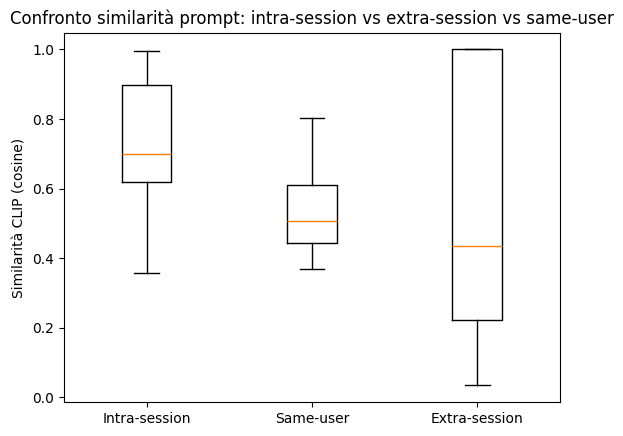

In [46]:
def plot_session_similarity(
    intra_sims: list[float],
    extra_sims: list[float],
    user_sims:  list[float]
) -> None:
    """
    Boxplot comparativo delle tre distribuzioni:
      - Intra-session
      - Extra-session
      - Same-user (senza sessione)
    """
    plt.figure()
    plt.boxplot(
        [intra_sims, user_sims, extra_sims],
        tick_labels=['Intra-session', 'Same-user', 'Extra-session']
    )
    plt.ylabel("Similarità CLIP (cosine)")
    plt.title("Confronto similarità prompt: intra-session vs extra-session vs same-user")
    plt.show()
    
plot_session_similarity(intra, extra, user)


In [33]:
session_gaps = [5, 10, 20, 30, 60, 120]
sims_by_gap = {
    gap: compute_intra_session_sims(manager, num_sessions=50, session_gap=gap, max_prompts=None)
    for gap in session_gaps
}

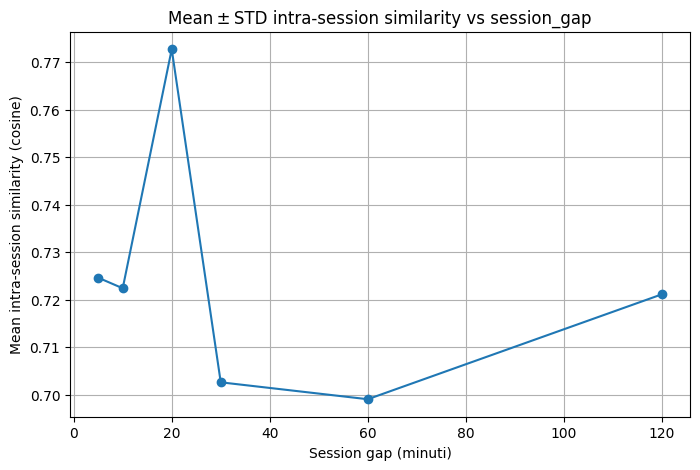

Miglior session_gap = 20 min  (mean sim = 0.7727)


In [34]:
means = []
for gap in session_gaps:
    vals = sims_by_gap[gap]
    means.append(np.mean(vals) if vals else 0.0)

plt.figure(figsize=(8,5))
plt.errorbar(
    session_gaps, means,
    marker='o', linestyle='-', capsize=5
)
plt.xlabel("Session gap (minuti)")
plt.ylabel("Mean intra‐session similarity (cosine)")
plt.title("Mean ± STD intra‐session similarity vs session_gap")
plt.grid(True)
plt.show()

best_gap = session_gaps[np.argmax(means)]
print(f"Miglior session_gap = {best_gap} min  (mean sim = {means[session_gaps.index(best_gap)]:.4f})")


## Cache similarity con politiche di eviction

LRU (Least Recently Used) e LFU (Least Frequently Used) e TTL (Time To Live) per la gestione della cache.

In [35]:
class SimilarityLRUCache:
    """Cache similarity + eviction LRU"""
    def __init__(self, capacity: int, threshold: float):
        self.capacity = capacity
        self.threshold = threshold
        # ordered dict: prompt -> (embedding)
        self.cache = OrderedDict()

    def query(self, prompt: str) -> bool:
        """
        Se esiste un item in cache con sim >= threshold -> hit, aggiorna MRU.
        Altrimenti -> miss.
        """
        q_emb = embed_prompt(prompt)
        best_key, best_sim = None, -1.0
        # cerca best match
        for key, emb in self.cache.items():
            sim = float((emb @ q_emb.T).item())
            if sim > best_sim:
                best_key, best_sim = key, sim
        if best_sim >= self.threshold:
            # hit: aggiorna ordine
            self.cache.move_to_end(best_key)
            return True
        # miss
        self._add(prompt, q_emb)
        return False

    def _add(self, prompt: str, emb: torch.Tensor):
        if len(self.cache) >= self.capacity:
            # rimuovi LRU
            self.cache.popitem(last=False)
        self.cache[prompt] = emb

class SimilarityLFUCache:
    """Cache similarity + eviction LFU"""
    def __init__(self, capacity: int, threshold: float):
        self.capacity = capacity
        self.threshold = threshold
        # store prompt -> embedding, and freq count
        self.cache = {}
        self.freq = defaultdict(int)

    def query(self, prompt: str) -> bool:
        q_emb = embed_prompt(prompt)
        best_key, best_sim = None, -1.0
        for key, emb in self.cache.items():
            sim = float((emb @ q_emb.T).item())
            if sim > best_sim:
                best_key, best_sim = key, sim
        if best_sim >= self.threshold:
            # hit: incrementa freq
            self.freq[best_key] += 1
            return True
        # miss
        self._add(prompt, q_emb)
        return False

    def _add(self, prompt: str, emb: torch.Tensor):
        if len(self.cache) >= self.capacity:
            # rimuovi LFU
            min_freq = min(self.freq.values())
            # trova una chiave con freq minima
            for key, f in list(self.freq.items()):
                if f == min_freq:
                    del self.cache[key]
                    del self.freq[key]
                    break
        self.cache[prompt] = emb
        self.freq[prompt] = 1

class SimilarityTTLCache:
    """Cache similarity + eviction TTL (in numero di richieste)"""
    def __init__(self, capacity: int, threshold: float, ttl: int):
        self.capacity = capacity
        self.threshold = threshold
        self.ttl = ttl
        self.cache = {}    # prompt -> emb (1‑D tensor)
        self.seen = {}     # prompt -> last_seen_request_index

    def query(self, prompt: str, t: int) -> bool:
        # 1) expire old entries
        expired = [p for p, ts in self.seen.items() if t - ts > self.ttl]
        for p in expired:
            del self.cache[p]
            del self.seen[p]

        # 2) similarity search
        q_emb = embed_prompt(prompt).squeeze()
        best_key, best_sim = None, -1.0
        for key, emb in self.cache.items():
            emb = emb.squeeze()
            sim = F.cosine_similarity(q_emb.unsqueeze(0), emb.unsqueeze(0), dim=1).item()
            if sim > best_sim:
                best_sim, best_key = sim, key

        if best_sim >= self.threshold:
            self.seen[best_key] = t
            return True

        # MISS: aggiungi (ed eventualmente evict)
        if len(self.cache) >= self.capacity:
            oldest = min(self.seen, key=lambda k: self.seen[k])
            del self.cache[oldest]; del self.seen[oldest]
        self.cache[prompt] = q_emb
        self.seen[prompt] = t
        return False



### Chaching test

In [36]:
random.seed(42)
NUM_REQUESTS  = 1500      # numero di richieste da simulare
CACHE_SIZE    = 500      # dimensione cache
SIM_THRESHOLD = 0.8      # soglia di similarità
TTL_VALUES    = [10, 50, 100, 200]  # diversi TTL da testare

# prepariamo prompt generator
prompt_fn = manager.retRandomPrompt()

# funzioni di simulazione
def simulate_standard(cache_obj):
    hits = 0
    for _ in range(NUM_REQUESTS):
        p = prompt_fn()
        if cache_obj.query(p):
            hits += 1
    return hits / NUM_REQUESTS

def simulate_ttl(ttl):
    cache = SimilarityTTLCache(CACHE_SIZE, SIM_THRESHOLD, ttl)
    hits = 0
    for t in range(NUM_REQUESTS):
        p = prompt_fn()
        if cache.query(p, t):
            hits += 1
    return hits / NUM_REQUESTS

# esegui simulazioni
results = {}

# LRU e LFU
results["LRU"] = simulate_standard(SimilarityLRUCache(CACHE_SIZE, SIM_THRESHOLD))
results["LFU"] = simulate_standard(SimilarityLFUCache(CACHE_SIZE, SIM_THRESHOLD))

# TTL per vari parametri
for ttl in TTL_VALUES:
    results[f"TTL={ttl}"] = simulate_ttl(ttl)


KeyboardInterrupt: 

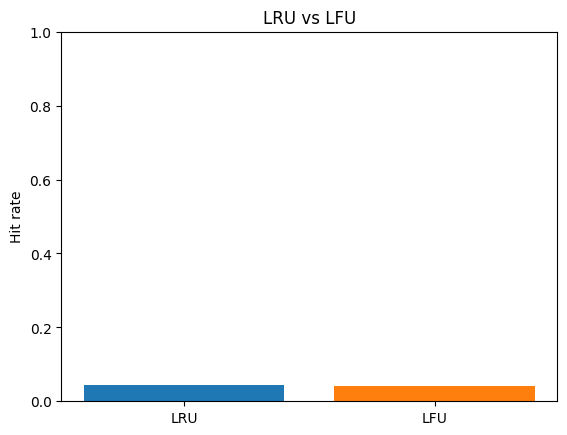

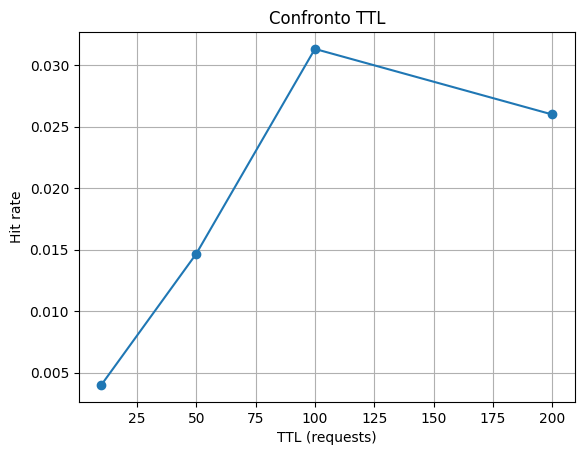

    policy  hit_rate
0      LRU  0.044667
1      LFU  0.040667
2   TTL=10  0.004000
3   TTL=50  0.014667
4  TTL=100  0.031333
5  TTL=200  0.026000


In [ ]:
# stampa tabella
df_res = pd.DataFrame([
    {"policy": k, "hit_rate": v} for k, v in results.items()
])

# separa LRU/LFU
plt.figure()
for pol in ["LRU", "LFU"]:
    hr = df_res[df_res.policy==pol].hit_rate.values[0]
    plt.bar(pol, hr)
plt.ylim(0,1)
plt.ylabel("Hit rate")
plt.title("LRU vs LFU")
plt.show()

# plot TTL
plt.figure()
ttl_rows = df_res[df_res.policy.str.startswith("TTL=")]
vals = [float(x.split("=")[1]) for x in ttl_rows.policy]
hrs  = ttl_rows.hit_rate.tolist()
plt.plot(vals, hrs, marker="o")
plt.xlabel("TTL (requests)")
plt.ylabel("Hit rate")
plt.title("Confronto TTL")
plt.grid(True)
plt.show()

print(df_res)


Caricati 100 prompt per la simulazione.
Simulazione LRU: cap=5, th=0.7
Simulazione LRU: cap=5, th=0.8
Simulazione LRU: cap=5, th=0.9
Simulazione LRU: cap=10, th=0.7
Simulazione LRU: cap=10, th=0.8
Simulazione LRU: cap=10, th=0.9
Simulazione LRU: cap=20, th=0.7
Simulazione LRU: cap=20, th=0.8
Simulazione LRU: cap=20, th=0.9
Simulazione LRU: cap=50, th=0.7
Simulazione LRU: cap=50, th=0.8
Simulazione LRU: cap=50, th=0.9


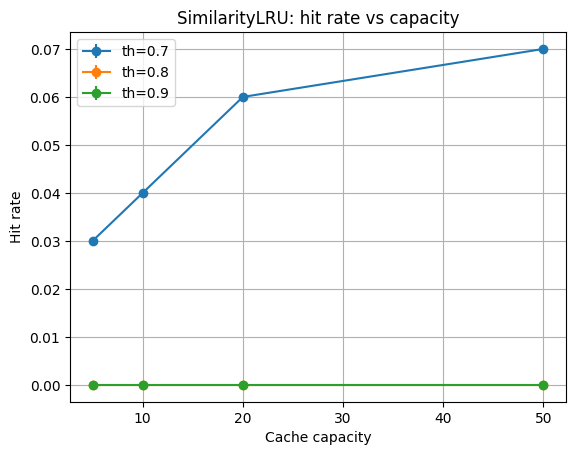

In [ ]:
def simulate_cache(cache_cls, capacity, threshold, workload, num_runs=3):
    metrics = {'hit_rate': [], 'evictions': [], 'comparisons': []}
    for _ in range(num_runs):
        cache = cache_cls(capacity=capacity, threshold=threshold)
        hits = evictions = comparisons = 0
        # opzionale: aggiungi cache.last_comparisons e cache.eviction_count
        for t, p in enumerate(workload):
            if cache.query(p):
                hits += 1
            # evictions += cache.eviction_count_delta
            # comparisons += cache.last_comparisons
        n = len(workload)
        metrics['hit_rate'].append(hits / n)
        metrics['evictions'].append(evictions)
        metrics['comparisons'].append(comparisons)
    # ritorna media e std
    return {
      k: (np.mean(v), np.std(v)) for k, v in metrics.items()
    }

# 1) prepara workload & embedding cache
raw_prompts = manager.getPrompts(limit=100, shuffle=True)
# precompute embeddings to speed up
emb_cache = {p: embed_prompt(p) for p in raw_prompts}
print (f"Caricati {len(raw_prompts)} prompt per la simulazione.")
# 2) definisci parametri
capacities = [5, 10, 20, 50]
thresholds = [0.7, 0.8, 0.9]

# 3) sweep su LRU
results = {}
for cap, th in itertools.product(capacities, thresholds):
    print(f"Simulazione LRU: cap={cap}, th={th}")
    workload = raw_prompts[:]  # o un sottoinsieme
    metrics = simulate_cache(SimilarityLRUCache, cap, th, workload)
    results[(cap, th)] = metrics

# 4) plot hit_rate vs capacity (una linea per threshold)
plt.figure()
for th in thresholds:
    rates = [results[(cap,th)]['hit_rate'][0] for cap in capacities]
    stds  = [results[(cap,th)]['hit_rate'][1] for cap in capacities]
    plt.errorbar(capacities, rates, yerr=stds, marker='o', label=f'th={th}')
plt.xlabel("Cache capacity")
plt.ylabel("Hit rate")
plt.title("SimilarityLRU: hit rate vs capacity")
plt.legend()
plt.grid(True)
plt.show()


Feature importance (η²):
  user_corr      → 0.7709
  session_corr   → 0.7492


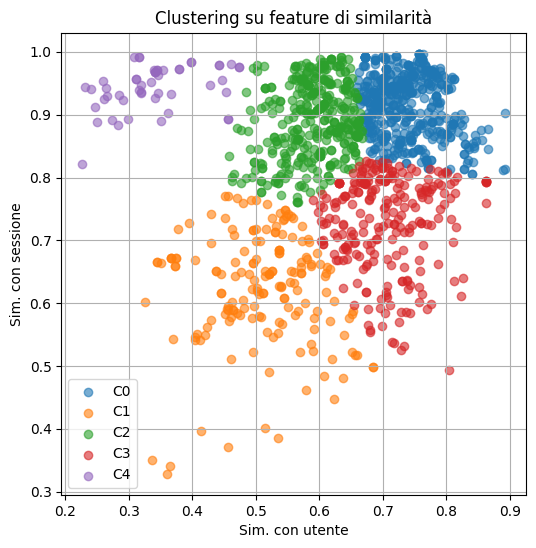

In [ ]:
# --- 1) Usa getSessionsPrompts per il gap di 30'
# manager.getSessionsPrompts(session_gap, limit, shuffle)
user_sessions = manager.getSessionsPrompts(session_gap=30, limit=2, shuffle=False)

# --- 2) Costruisci un DataFrame "flat" sessionale
rows = []
for user, sessions in user_sessions.items():
    for sess_id, prompts in sessions.items():
        for p in prompts:
            rows.append({
                'user_name': user,
                'prompt': p,
                'session_id': sess_id
            })
sess_df = pd.DataFrame(rows)

# --- 3) Calcola embedding per ogni prompt
# Nota: se hai molti duplicati, potresti dedup e poi merge, ma per chiarezza:
sess_df['emb'] = sess_df['prompt'].apply(lambda p: embed_prompt(p).squeeze())

# --- 4) Costruisci i prototipi medi
user_proto = sess_df.groupby('user_name')['emb'] \
                    .apply(lambda embs: torch.stack(embs.tolist()).mean(0))
session_proto = sess_df.groupby('session_id')['emb'] \
                       .apply(lambda embs: torch.stack(embs.tolist()).mean(0))

# funzione di similarità
def cos_sim(a, b):
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0), dim=1).item()

# --- 5) Calcola le due feature
sess_df['user_corr'] = sess_df.apply(
    lambda r: cos_sim(r['emb'], user_proto.loc[r['user_name']]),
    axis=1
)
sess_df['session_corr'] = sess_df.apply(
    lambda r: cos_sim(r['emb'], session_proto.loc[r['session_id']]),
    axis=1
)

# --- 6) Clustering (es. KMeans)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
sess_df['cluster'] = kmeans.fit_predict(sess_df[['user_corr','session_corr']])

# --- 7) η² per variabili numeriche
def eta_squared(x: pd.Series, clusters: pd.Series) -> float:
    mu = x.mean()
    ss_between = sum(
        (clusters == cl).sum() * (x[clusters == cl].mean() - mu)**2
        for cl in clusters.unique()
    )
    ss_total = ((x - mu)**2).sum()
    return float(ss_between / ss_total) if ss_total else 0.0

features = ['user_corr', 'session_corr']
etas = {f: eta_squared(sess_df[f], sess_df['cluster']) for f in features}

# --- 8) Risultati
print("Feature importance (η²):")
for feat, score in sorted(etas.items(), key=lambda kv: kv[1], reverse=True):
    print(f"  {feat:14s} → {score:.4f}")

# --- 9) (Opzionale) Scatter plot
plt.figure(figsize=(6,6))
for cl in range(n_clusters):
    sub = sess_df[sess_df['cluster']==cl]
    plt.scatter(sub['user_corr'], sub['session_corr'], alpha=0.6, label=f'C{cl}')
plt.xlabel("Sim. con utente")
plt.ylabel("Sim. con sessione")
plt.title("Clustering su feature di similarità")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def print_similarity_examples(
    manager,
    num_queries: int = 5,
    search_limit: int = 1000,
    threshold: float = 0.85
):
    """
    Estrae `search_limit` prompt dal manager, ne campiona `num_queries` come 
    domande, calcola embedding e per ognuna trova nel pool il prompt più simile 
    (escludendo se stesso). Se la similarità ≥ threshold, lo stampa.
    """
    # 1) Prendo un pool di prompt da cercare
    pool = manager.getPrompts(limit=search_limit, shuffle=True)
    if len(pool) < num_queries + 1:
        raise ValueError("Pool troppo piccolo per estrarre le query")

    # 2) Scelgo le query
    queries = random.sample(pool, num_queries)

    # 3) Pre-calcolo tutti gli embedding in un dict
    emb_dict = {p: embed_prompt(p).squeeze() for p in pool}

    print(f"=== Examples of prompt similarity (threshold={threshold}) ===\n")
    # 4) Per ogni query cerco il match migliore
    for q in queries:
        q_emb = emb_dict[q]
        best_p, best_sim = None, -1.0
        for p, emb in emb_dict.items():
            if p == q:
                continue
            sim = float(F.cosine_similarity(q_emb.unsqueeze(0), emb.unsqueeze(0), dim=1).item())
            if sim > best_sim:
                best_sim, best_p = sim, p

        # 5) Se supera la soglia, stampo; altrimenti avviso che non ho trovato
        print(f"Query: \"{q}\"")
        if best_sim >= threshold:
            print(f" → Similar: \"{best_p}\"  (sim = {best_sim:.3f})\n")
        else:
            print(f" → Nessun match ≥ threshold (best sim = {best_sim:.3f})\n")

print_similarity_examples(
    manager,
    num_queries=3,     # quante query random
    search_limit=5000,  # dimensione del pool in cui cercare
    threshold=0.7     # soglia minima di similarità per conside­rare un buon match
)


=== Examples of prompt similarity (threshold=0.7) ===

Query: "black color, stock image "
 → Similar: "black png "  (sim = 0.870)

Query: "robot ninja mask helmet metal gear solid training suit swat commando, aesthetic octane render, 8 k hd resolution, by ilya kuvshinov and cushart krentz and gilleard james, by carl warner and jim woodring, trending on artstation : 1. 5, sweet joy harmony color scheme "
 → Similar: " robot ninja helmet mask fantasy art overwatch and heartstone Video game icon, 2d game art gta cover , official fanart behance hd artstation by Jesper Ejsing, by RHADS, Makoto Shinkai and Lois van baarle, ilya kuvshinov, rossdraws "  (sim = 0.725)

Query: "a painting of a boy in a crystal box watching a colorful sunrise futuristic city surrounded by clouds, cyberpunk art by yoshitaka amano and alena aenami, cg society contest winner, retrofuturism, matte painting, apocalypse landscape, cityscape "
 → Nessun match ≥ threshold (best sim = 0.538)



## VECCHIO GRAFICO SULLE POLICY DI CACHING PRIMA DELLA DASH LIVE UPDATE

In [ ]:
import panel as pn
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# Assicurati di aver già importato le cache e il manager
# from similarity_caches import LRUCache, LFUCache, TTLCache
# from prompt_dataset_manager import PromptDatasetManager

pn.extension()
dim = manager.emb_matrix.shape[1]

# Prepara le due trace
TRACE_LEN = 2000
seq_requests = manager.sample_prompts(num_prompts=TRACE_LEN, random_order=False)
rand_requests = manager.sample_prompts(num_prompts=TRACE_LEN, random_order=True)

# Widget di controllo
policy_select   = pn.widgets.Select(name='Policy',    options=['LRU','LFU','TTL'],     value='LRU')
capacity_slider = pn.widgets.IntSlider(name='Capacity', start=50, end=2000, step=50, value=500)
threshold_slider= pn.widgets.FloatSlider(name='Threshold', start=0.5, end=1.0, step=0.05, value=0.8)
ttl_slider      = pn.widgets.IntSlider(name='TTL',      start=10, end=500, step=10,    value=100)
trace_select    = pn.widgets.RadioButtonGroup(name='Trace', options=['Sequential','Random'], button_type='primary')
run_button      = pn.widgets.Button(name='Run Simulation', button_type='success')

# Output
text_hit_rate   = pn.widgets.StaticText(name='Hit Rate', value='0.00')
text_cache_size = pn.widgets.StaticText(name='Cache Occupancy', value='0')

plot_pane = pn.pane.Matplotlib(sizing_mode='stretch_width', height=300)

def run_simulator(event):
    # Seleziona trace
    requests = seq_requests if trace_select.value=='Sequential' else rand_requests

    # Instanzia cache scelto
    cap, th, ttl = capacity_slider.value, threshold_slider.value, ttl_slider.value
    if policy_select.value=='LRU':
        cache = LRUCache(cap, th, dim, use_faiss=True)
    elif policy_select.value=='LFU':
        cache = LFUCache(cap, th, dim, use_faiss=True)
    else:
        cache = TTLCache(cap, th, dim, ttl, use_faiss=True)

    hits, sizes = 0, []
    rates = []
    for i, (key, emb) in enumerate(requests, start=1):
        if cache.query(key, emb):
            hits += 1
        sizes.append(len(cache.index.keys))
        rates.append(hits / i)

    # Aggiorna metriche testuali
    text_hit_rate.value   = f"{rates[-1]:.3f}"
    text_cache_size.value = f"{sizes[-1]}/{cache.capacity}"

    # Disegna grafico
    #plt.figure(figsize=(8,3))
    plt.plot(rates, label='Hit Rate')
    plt.plot(np.array(sizes)/cache.capacity, label='Occupancy (%)')
    plt.legend(loc='upper right')
    plt.xlabel('Request')
    plt.tight_layout()
    plot_pane.object = plt.gcf()

run_button.on_click(run_simulator)

# Layout e visualizzazione
dashboard = pn.Column(
    pn.Row(
        pn.Column(policy_select,  align='start'),
        pn.Column(run_button, trace_select, align='end')
    ),
    pn.Row(text_hit_rate, text_cache_size),
    plot_pane,
    pn.Row(capacity_slider, threshold_slider, ttl_slider)
)

# Mostra nel notebook o nel browser
dashboard.servable(title='Similarity Cache Simulator')
# dashboard.show()  # Per visualizzare direttamente nel browser, se necessario

